## 모듈 임포트

In [39]:
import numpy as np
import pandas as pd
import plotly.offline as pyo
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import cm
import requests
import json
import datetime as dt
from pandas import DataFrame
from matplotlib import pyplot
from IPython.display import SVG   # jupyter 상에서 SVG 이미지를 표시하기 위한 패키지
from bs4 import BeautifulSoup
plt.rc('font', family='Malgun Gothic')
import pickle
from tqdm.notebook import tqdm

## 데이터 불러들이기

In [40]:
df = pd.read_csv('지역별_2010부터_감염병발생빈도.csv')
data = pd.read_csv('지역별_2018부터_10만명당감염병발생비율.csv')
age = pd.read_csv('연령_전체.csv', encoding = 'euc-kr',header = None)
with open('season.pickle', 'rb') as f:
    season = pickle.load(f)

## 시각화를 위한 함수

In [41]:
index_dict = {
        '강원': '강원도',
        '경기': '경기도',
        '경남': '경상남도',
        '경북': '경상북도',
        '광주': '광주광역시',
        '대구': '대구광역시',
        '대전': '대전광역시',
        '부산': '부산광역시',
        '서울': '서울특별시',
        '세종': '세종특별자치시',
        '울산': '울산광역시',
        '인천': '인천광역시',
        '전남': '전라남도',
        '전북': '전라북도',
        '제주': '제주특별자치도',
        '충남': '충청남도',
        '충북': '충청북도'}

##############################################
# 총 감염병수를 연령별로 나눠 파이차트 그리기#
##############################################
def plot_pie_chart_by_age(disease):  
    age = pd.read_csv('연령_전체.csv', encoding = 'euc-kr',header = None)
    colum = ['나이','에볼라바이러스병 ','마버그열','라싸열','크리미안콩고출혈열','남아메리카출혈열','리프트밸리열','두창','페스트','탄저','보툴리눔독소증','야토병','신종감염병증후군',
        '중증급성호흡기증후군(SARS)','중동호흡기증후군(MERS)','동물인플루엔자 인체감염증','신종인플루엔자','디프테리아','수두','홍역','콜레라','장티푸스', '파라티푸스',
        '세균성이질','장출혈성대장균감염증','A형간염','백일해','유행성이하선염','풍진(2018년이전)','풍진(선천성)','풍진(후천성)','폴리오','수막구균 감염증','b형헤모필루스인플루엔자',
        '폐렴구균 감염증','한센병','성홍열','반코마이신내성황색포도알균(VRSA) 감염증','카바페넴내성장내세균속균종(CRE) 감염증','E형간염','파상풍','B형간염','일본뇌염',
        'C형간염','말라리아','레지오넬라증','비브리오패혈증','발진티푸스','발진열','쯔쯔가무시증','렙토스피라증','브루셀라증','공수병','신증후군출혈열','크로이츠펠트-야콥병(CJD) 및 변종크로이츠펠트-야콥병(vCJD)',
        '황열','뎅기열','큐열','웨스트나일열','라임병','진드기매개뇌염','유비저','치쿤구니야열','중증열성혈소판감소증후군(SFTS)','지카바이러스감염증']
    age.columns = colum
    group_names = age['나이'][1:]
    group_sizes = age[disease][1:]

    # Pie chart
    plt.figure(figsize = (7,7))
    plt.pie(group_sizes, 
            labels=group_names, 
    #         colors= cs,
            autopct='%1.2f%%', # second decimal place
            shadow=True, 
            textprops={'fontsize': 10}) # text font size
    plt.axis('equal') #  equal length of X and Y axis
    plt.title('{} 연령별 총 분포'.format(disease), fontsize=20)
    plt.show()

##############################################
# 총 감염병 확진자를 월별로 그냥 그리기######
##############################################
def montly_trend(disease):
    df = pd.read_csv('지역별_2010부터_감염병발생빈도.csv')
    df['시'] = df['구분'].apply(lambda x : x[:2])
    df[disease] =  df[disease].apply(lambda x : 0 if x == '-' else float(x))
    date = df[[disease,'날짜', '구분', '시', '년']].groupby('날짜').sum().reset_index()  
    plt.figure(figsize = (30,10))
    plt.plot(date['날짜'][:-1], date[disease][:-1])
    plt.xticks(rotation=45)
    plt.title('{} 월별 증감수'.format(disease), fontdict = {'fontsize': 40})
    plt.show()

    
###########################################################################
# 10만명당 발생률 비율로 , 가장 최근달인 8월을 기준으로 발생률 나눔######
#########################################################################
def preprocess_plot(disease):
    data = pd.read_csv('지역별_2018부터_10만명당감염병발생비율.csv')
    data[disease] =  data[disease].apply(lambda x : 0 if x == '-' else float(x))
    data['지역'] = data['구분'].apply(lambda x : x[:2])
    
    last = data[data['날짜'] == data['날짜'].values.max()].groupby('지역').mean().reset_index()
    k =last[['지역', disease]]
    결과df = k.set_index('지역')
    최종df = 결과df.rename(index=index_dict)
    return 최종df


###########################################################################
# 0.2, 0.4, 0.6, 0.8, 기준으로 나눴읍니다     (진해질수록 많아)      ######
#########################################################################
def make_quantile(data, disease):
    Q1 = data[disease].quantile(.20) # 7월달 기준 20% 미만은 안전(대체)
    Q2 = data[disease].quantile(.40)
    Q3 = data[disease].quantile(.90)
    Q4 = data[disease].quantile(.975)
    
    return Q1, Q2, Q3, Q4
    
def ratio_disease_plot(data, disease, Q1, Q2, Q3, Q4):

    with open('Administrative_divisions_map_of_South_Korea.svg', 'r', encoding='utf-8') as f:
        map_svg = f.read()

    soup = BeautifulSoup(map_svg, "lxml")
    glist = soup.select("svg > g[id], svg > path[id]")

    colors = ['#eaeceb', '#bfbfbf', '#b2e1ff', '#15a8de', '#118ac9']
    for item in glist:
        # svg 파일에서 추출한 id값이 데이터프레임의 index에 속하지 않았다면 다음으로 넘어감
        if item['id'] not in data.index:
            continue

        # item['id'] --> 지도에서 뽑아낸 id
        # 최종df에서 인덱스 이름이 지도에서 뽑아낸 id와 일치하는 행의 의료기관수를 추출
        count = data.loc[ item['id'], disease ]

        # 누적확진자수에 따라 단계값 설정 (단계는 색상값의 수에 따름)
        if Q4 == 0:
            color_index = 0
        else:
            if count <= Q1: color_index = 0
            elif count < Q2: color_index = 1
            elif count < Q3: color_index = 2
            elif count < Q4: color_index = 3
            else: color_index = 4

        #print("%s: 확진자수: %d, 색상인덱스: %d" % (item['id'], count, color_index))

        # item에 fill 속성이 있는 경우 -> 세종특별자치시
        if 'fill' in item.attrs:
            item['fill'] = colors[color_index]
        # 그렇지 않은 경우 -> 나머지 지역
        else:
            # 현재 요소(item)의 하위 항목들에게 색상을 적용해야 한다.
            for p in item.select('g, path'):
                if 'fill' in p.attrs:
                    p['fill'] = colors[color_index]

    지역별확진자svg = soup.prettify()
    return SVG(지역별확진자svg)

def oneshot(disease):
    montly_trend(disease)
    plot_pie_chart_by_age(disease)
    최종df = preprocess_plot(disease)
    print(최종df.loc[최종df[disease].sort_values()[::-1][:5].index])
    Q1, Q2, Q3, Q4 = make_quantile(최종df, disease)
    return ratio_disease_plot(최종df, disease, Q1, Q2, Q3, Q4)
    

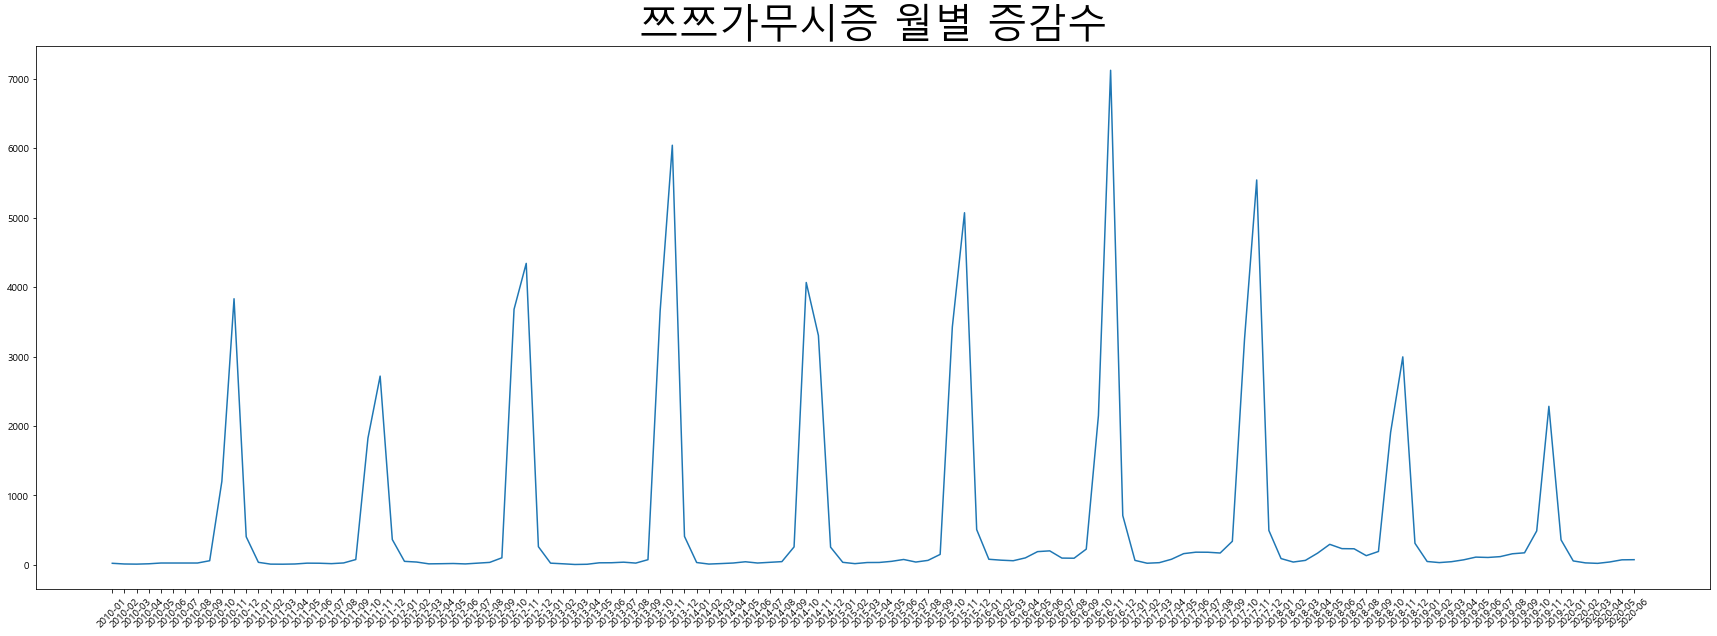

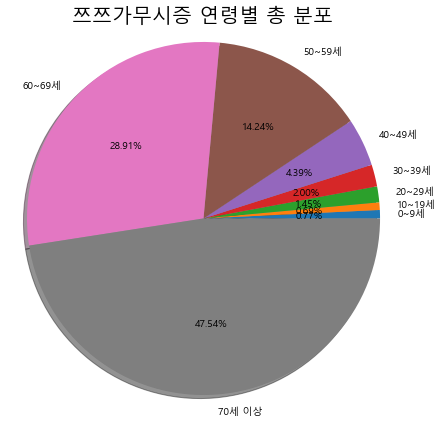

           쯔쯔가무시증
지역               
전라남도     1.255000
전라북도     0.817500
경상남도     0.582000
충청남도     0.479444
세종특별자치시  0.310000


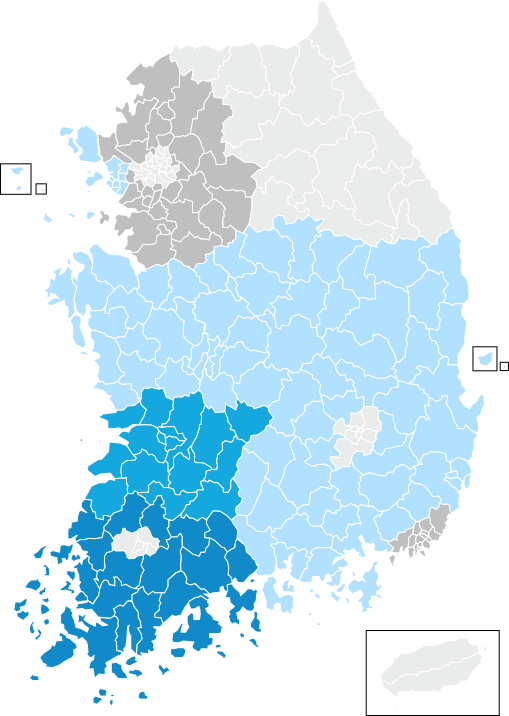

In [42]:
oneshot('쯔쯔가무시증')

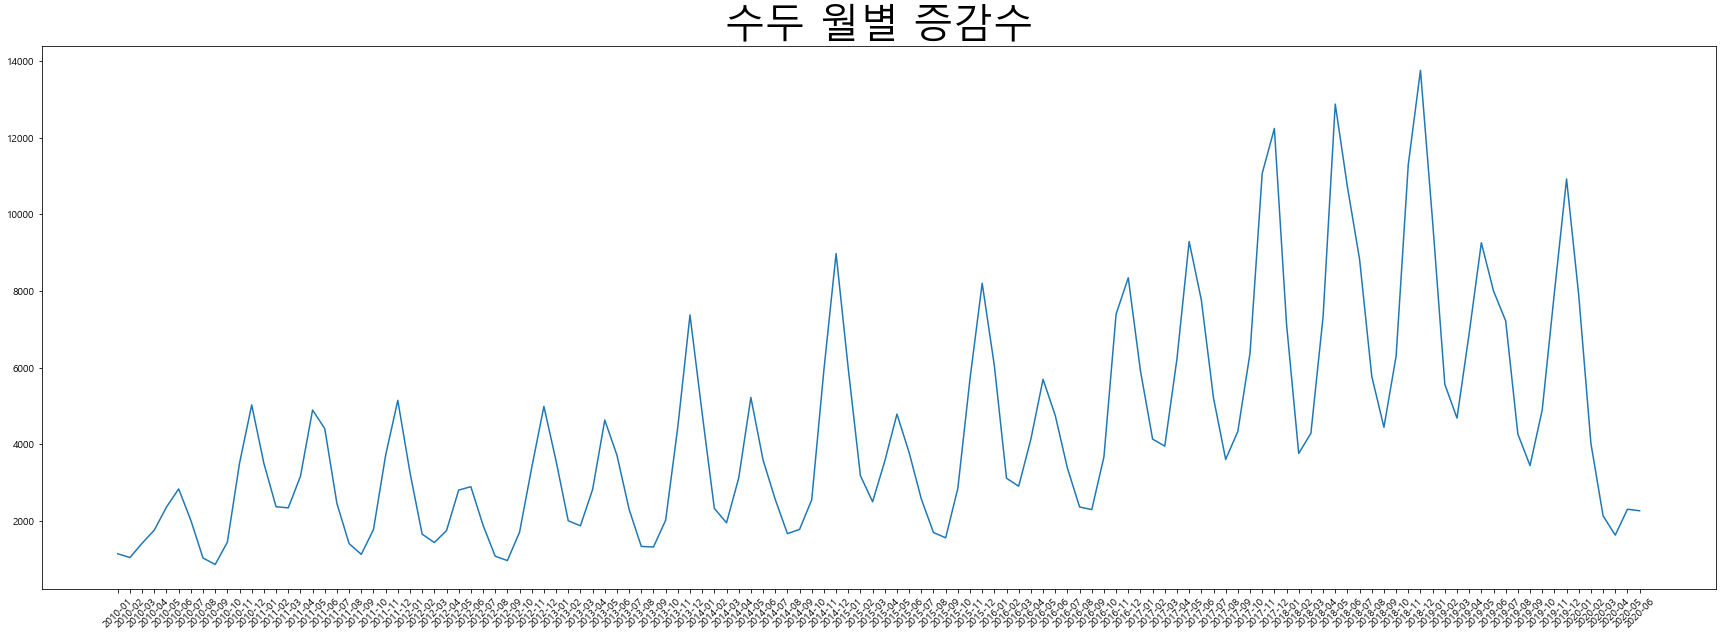

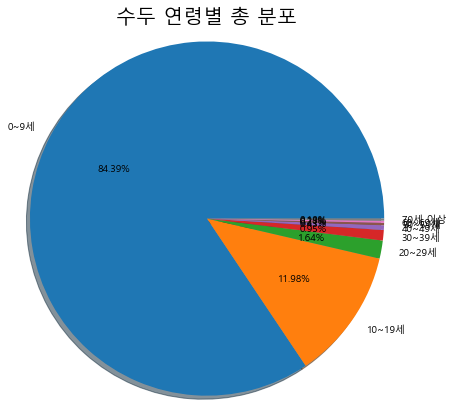

               수두
지역               
광주광역시    5.404000
제주특별자치도  5.155000
전라남도     4.333636
울산광역시    4.328000
대구광역시    4.187500


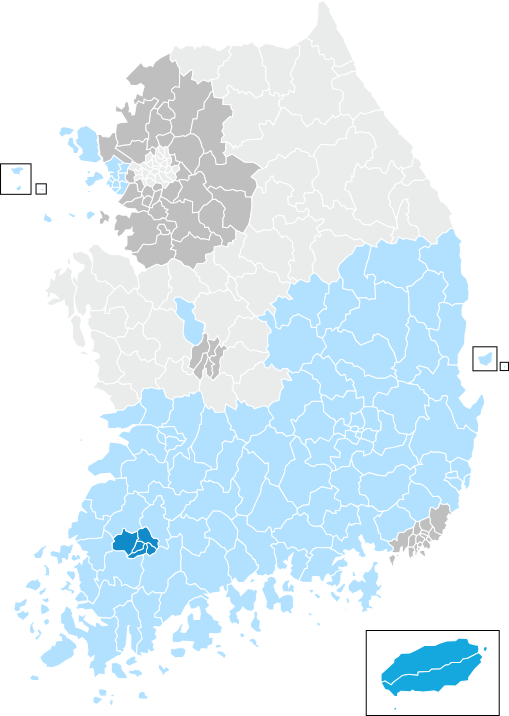

In [34]:
oneshot('수두')